## Back Test Results Binary Classification

In [1]:
import pandas as pd
from datetime import datetime, timezone
from pycaret.datasets import get_data
from pycaret.classification import *
import yaml
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    pair = cfg['currency']['pair_2']
    dt = cfg['model']['dt']
    et = cfg['model']['et']
    knn = cfg['model']['knn'] 
    rf = cfg['model']['rf']
    ada = cfg['model']['ada']
    gbc = cfg['model']['gbc']
    svm = cfg['model']['svm']
    lightgbm = cfg['model']['lightgbm']
    lr = cfg['model']['lr']
    ridge = cfg['model']['ridge']
    lda = cfg['model']['lda']
    qda = cfg['model']['qda']
    nb = cfg['model']['nb']
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']

In [3]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [4]:
dataset = pd.read_csv('Back_Test_Result.csv')
dataset.shape

(4000, 11)

In [5]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,3595.0,65.0,Bearish,61.0,BUY,25.0,SELL,45.0,SELL,70.0,SELL
1,1061.0,19.0,Bearish,87.0,SELL,60.0,BUY,89.0,SELL,64.0,SELL
2,4313.0,24.0,Bearish,57.0,BUY,82.0,SELL,76.0,SELL,78.0,SELL
3,9060.0,40.0,Bearish,11.0,BUY,89.0,SELL,35.0,BUY,8.0,BUY
4,2895.0,37.0,Bullish,48.0,BUY,6.0,BUY,54.0,BUY,1.0,BUY


## Drop Predictions with Less than 20% LR Fit

In [6]:
dataset = dataset[dataset['Current_Market_Fit'] > 20]
dataset = dataset.reset_index()
del dataset['index']

In [7]:
dataset.shape

(2842, 11)

## One-Hot Encoding

In [8]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_Prediction'] = dataset['Rec1_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_Prediction'] = dataset['Rec2_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_Prediction'] = dataset['Rec3_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec4_Prediction'] = dataset['Rec4_Prediction'].replace(['BUY','SELL'],[1,-1])

In [9]:
dataset['Rec1_Score'] = dataset['Rec1_Score'] * dataset['Rec1_Prediction']
dataset['Rec2_Score'] = dataset['Rec2_Score'] * dataset['Rec2_Prediction']
dataset['Rec3_Score'] = dataset['Rec3_Score'] * dataset['Rec3_Prediction']
dataset['Rec4_Score'] = dataset['Rec4_Score'] * dataset['Rec4_Prediction']

In [10]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Rec1_Prediction',
    'Rec2_Prediction',
    'Rec3_Prediction',
    'Rec4_Prediction',
], axis=1)

In [11]:
dataset.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,0,61.0,-25.0,-45.0,-70.0
1,0,57.0,-82.0,-76.0,-78.0
2,0,11.0,-89.0,35.0,8.0
3,1,48.0,6.0,54.0,1.0
4,0,49.0,-1.0,90.0,-51.0


In [12]:
data = dataset.sample(frac=frac, random_state=random_state).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (2274, 5)
Unseen Data For Predictions: (568, 5)


# Create Unseen DataFrame

In [13]:
data_unseen.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,-68.0,-2.0,10.0,-65.0
1,1,77.0,69.0,-62.0,-18.0
2,0,92.0,-0.0,-66.0,70.0
3,1,-50.0,-57.0,7.0,12.0
4,1,-0.0,-31.0,45.0,6.0


In [14]:
exp_clf101 = setup(data = data, target = 'Current_Market', session_id=123, silent=True) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2274, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [15]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.5374,0.5341,0.5453,0.5474,0.5444,0.0748,0.0755,0.0510
et,Extra Trees Classifier,0.5342,0.5344,0.5416,0.5415,0.5407,0.0685,0.0687,0.0430
gbc,Gradient Boosting Classifier,0.5318,0.5402,0.6009,0.5352,0.5654,0.0618,0.0622,0.0200
lightgbm,Light Gradient Boosting Machine,0.5192,0.5341,0.5391,0.5264,0.5319,0.0380,0.0381,0.0130
ada,Ada Boost Classifier,0.5185,0.5033,0.5985,0.5223,0.5570,0.0351,0.0356,0.0160
dt,Decision Tree Classifier,0.5116,0.5114,0.5317,0.5199,0.5246,0.0228,0.0230,0.1200
knn,K Neighbors Classifier,0.5085,0.5054,0.5094,0.5157,0.5107,0.0172,0.0172,0.1160
qda,Quadratic Discriminant Analysis,0.4890,0.4875,0.5921,0.4962,0.5394,-0.0251,-0.0252,0.0040
svm,SVM - Linear Kernel,0.4871,0.0000,0.4943,0.4945,0.4938,-0.0262,-0.0262,0.1200
nb,Naive Bayes,0.4814,0.4910,0.6133,0.4905,0.5443,-0.0411,-0.0427,0.1190


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [16]:
best_model = gbc

In [17]:
MODEL = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5125,0.5101,0.5926,0.5161,0.5517,0.0230,0.0233
1,0.4969,0.5329,0.5500,0.5000,0.5238,-0.0070,-0.0070
2,0.4969,0.5142,0.6125,0.5000,0.5506,-0.0078,-0.0080
3,0.4906,0.4745,0.6000,0.4948,0.5424,-0.0203,-0.0208
4,0.5535,0.5582,0.5309,0.5658,0.5478,0.1077,0.1079
5,0.6164,0.6311,0.6914,0.6087,0.6474,0.2304,0.2327
6,0.5472,0.5586,0.6049,0.5506,0.5765,0.0923,0.0928
7,0.5472,0.5494,0.5802,0.5529,0.5663,0.0932,0.0933
8,0.4843,0.4805,0.5802,0.4947,0.5341,-0.0353,-0.0358
9,0.5723,0.5926,0.6667,0.5684,0.6136,0.1415,0.1438


In [18]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4875,0.5335,0.5802,0.4947,0.5341,-0.0274,-0.0278
1,0.5283,0.5133,0.5625,0.5294,0.5455,0.0562,0.0563
2,0.5157,0.4747,0.6375,0.5152,0.5698,0.0300,0.0308
3,0.5409,0.5323,0.6250,0.5376,0.5780,0.0808,0.0819
4,0.5157,0.5355,0.5432,0.5238,0.5333,0.0304,0.0304
5,0.5220,0.4940,0.6049,0.5269,0.5632,0.0410,0.0414
6,0.5786,0.5546,0.5309,0.5972,0.5621,0.1587,0.1598
7,0.5283,0.5120,0.5432,0.5366,0.5399,0.0560,0.0560
8,0.5535,0.5445,0.6296,0.5543,0.5896,0.1043,0.1053
9,0.5283,0.5256,0.6420,0.5306,0.5810,0.0524,0.0537


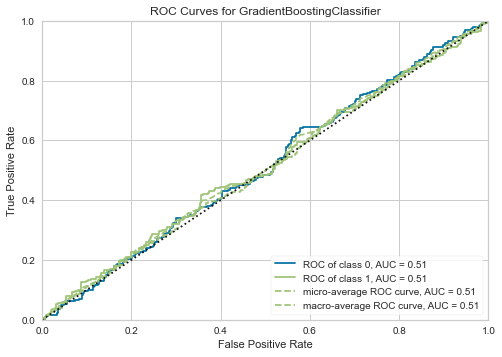

In [19]:
plot_model(TUNED_MODEL, plot = 'auc')

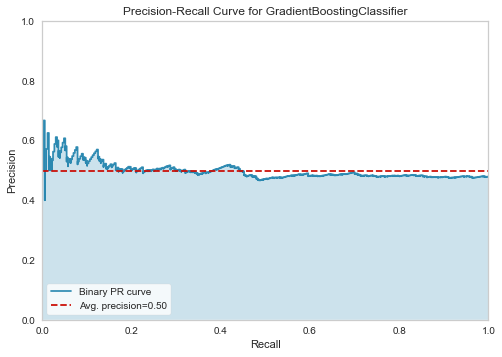

In [20]:
plot_model(TUNED_MODEL, plot = 'pr')

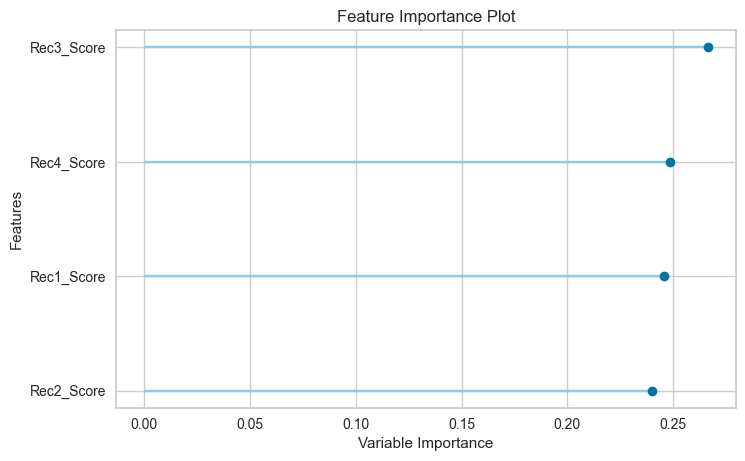

In [21]:
plot_model(TUNED_MODEL, plot='feature')

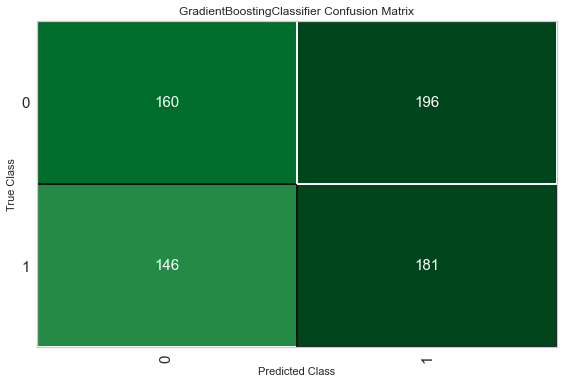

In [22]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [23]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.4993,0.5129,0.5535,0.4801,0.5142,0.0029,0.0030


In [24]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [25]:
print(FINAL_MODEL)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=7,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.05, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=140,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=0.35, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [26]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7789,0.8597,0.7829,0.7619,0.7722,0.5575,0.5577


In [27]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-68.0,-2.0,10.0,-65.0,1,0.5880
1,1,77.0,69.0,-62.0,-18.0,1,0.5320
2,0,92.0,-0.0,-66.0,70.0,0,0.5187
3,1,-50.0,-57.0,7.0,12.0,1,0.5692
4,1,-0.0,-31.0,45.0,6.0,1,0.5654


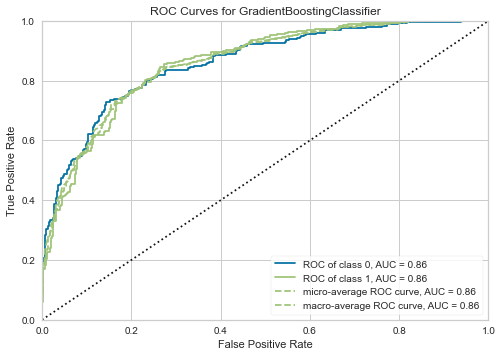

In [28]:
plot_model(FINAL_MODEL, plot = 'auc')

In [29]:
pkl_name = (today + "_" + best_model + "_" + pair)

In [30]:
save_model(FINAL_MODEL, pkl_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                             learning_rate=0.01, loss='deviance',
                                             max_depth=7, max_features='sqrt',
                                             max_leaf_nodes=None,
        

In [31]:
SAVED_FINAL_MODEL = load_model(pkl_name)

Transformation Pipeline and Model Successfully Loaded


In [32]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [33]:
new_prediction.head(20)

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-68.0,-2.0,10.0,-65.0,1,0.5880
1,1,77.0,69.0,-62.0,-18.0,1,0.5320
2,0,92.0,-0.0,-66.0,70.0,0,0.5187
3,1,-50.0,-57.0,7.0,12.0,1,0.5692
4,1,-0.0,-31.0,45.0,6.0,1,0.5654
5,0,-78.0,-29.0,27.0,93.0,1,0.5172
6,1,-75.0,26.0,0.0,-92.0,0,0.5248
7,1,-71.0,-90.0,-62.0,-3.0,0,0.5084
8,1,-41.0,-80.0,88.0,54.0,1,0.6283
9,0,12.0,9.0,-86.0,-37.0,0,0.5471


In [34]:
file = open(today + "_" + "binary_classification_log.txt", "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "Model: " + best_model + "\n" + \
            "Frac: " + str(frac) + "\n" + \
            "Random State: " + str(random_state) + "\n" )
file.close()